In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from legoblock import *
import aequitas

from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

class Categorizer:
    def __init__(self):
        1
        
    def fit(self, X):
        x = np.unique(X)
        self.cat2id = dict(zip(x, range(len(x))))
        self.id2cat = dict(zip(range(len(x)), x))
        self.nunique = len(x)
    
    def transform(self, X):
        return np.array(list(map(lambda x : self.cat2id[x], X)))
    
    def invtransform(self, X):
        return np.array(list(map(lambda x : self.id2cat[x], X)))
    

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/ekimetrics/ethical-ai-toolkit/main/data/german-risk-scoring.csv")

data["sex"] = data["Personal status and sex"].map(lambda x : x.split(":")[0])
#data = data.rename(columns = {"Age in years":"age"})

Y = data['Cost Matrix(Risk)'].replace({"Good Risk" : 1, "Bad Risk" : 0})
X = data.drop(columns = 'Cost Matrix(Risk)')


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train = X_train.copy()
X_test = X_test.copy()

cats = [
    'Status of existing checking account',
    'Credit history',
    'Purpose',
    'Savings account/bonds',
    'Present employment since',
    'Personal status and sex', 
    'Other debtors / guarantors',
    'Property',
    'Other installment plans',
    'Housing',
    'Job',
    'Telephone',
    'foreign worker',
    'sex'
       ]

numericals = [
    'Duration in month',
    'Credit amount',
    'Installment rate in percentage of disposable income',
    'Present residence since',
    'Age in years',
    'Number of existing credits at this bank',
    'Number of people being liable to provide maintenance for',
    
    
]

for elt in cats:
    data[elt] = data[elt].astype(str)
    
for elt in numericals:
    data[elt] = data[elt].astype(float)

variables = cats + numericals

def process_data(X_train, X_test, cats, numericals, one_hot = False):
    train = X_train.copy()
    test =  X_test.copy()
    categorizers = {}
    for elt in cats:
        train[elt].fillna('0', inplace = True)
        test[elt].fillna('0', inplace = True)
        categorizers[elt] = Categorizer()
        categorizers[elt].fit(pd.concat([train, test])[elt].values)
        train[elt] = categorizers[elt].transform(train[elt].values)
        test[elt] = categorizers[elt].transform(test[elt].values)
        if one_hot:
            m = max(train[elt].max(), test[elt].max())+1
            encoded_train = tf.keras.utils.to_categorical(train[elt].values, num_classes = m)
            encoded_test = tf.keras.utils.to_categorical(test[elt].values, num_classes = m)
            train[[f'{elt}_{i}' for i in range(m)]] = encoded_train
            test[[f'{elt}_{i}' for i in range(m)]] = encoded_test
            train.drop(columns = elt, inplace = True)
            test.drop(columns = elt, inplace = True)

    for elt in numericals:
        train[elt] = train[elt].fillna(0)
        test[elt] = test[elt].fillna(0)
    
#     train = train[variables]
#     test = test[variables]
    return train, test, categorizers

def build_inputs(df):
    dico = {}
    for elt in categoricals:
        dico[elt] = df[elt].values
    dico['num'] = df[numericals].values    
    return dico

X_train_proc, X_test_proc, categorizers = process_data(X_train, X_test, cats, numericals, one_hot = True)

# X_train = build_inputs(X_train)
# X_test = build_inputs(df_test)
# X_val = build_inputs(X_val)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(random_state=0, n_jobs = 8, max_iter = 500)
clf.fit(X_train_proc, y_train)

LogisticRegression(max_iter=500, n_jobs=8, random_state=0)

In [8]:
pred = clf.predict(X_test_proc)
print(accuracy_score(y_test, pred), f1_score(y_test, pred))

0.785 0.8532423208191126


In [17]:
cats_to_analyse = [
#     'Status of existing checking account',
#     'Credit history',
#     'Purpose',
#     'Savings account/bonds',
#     'Present employment since',
#     'Personal status and sex', 
#     'Other debtors / guarantors',
#     'Property',
#     'Other installment plans',
#     'Housing',
#     'Job',
#     'Telephone',
#     'foreign worker'
    'sex'
       ]

numericals_to_analyse = [
#     'Duration in month',
     'Credit amount',
#     'Installment rate in percentage of disposable income',
#     'Present residence since',
     'Age in years'#,
#     'Number of existing credits at this bank',
#     'Number of people being liable to provide maintenance for',
]

fields_to_analyse = cats_to_analyse + numericals_to_analyse

analysis = X_test[fields_to_analyse].copy()
analysis['score'] = pred
analysis['label_value'] = y_test

In [18]:
from aequitas.preprocessing import preprocess_input_df
df, _ = preprocess_input_df(analysis)

In [19]:
from aequitas.group import Group
g = Group()
xtab, _ = g.get_crosstabs(df)

<Figure size 1800x1080 with 0 Axes>

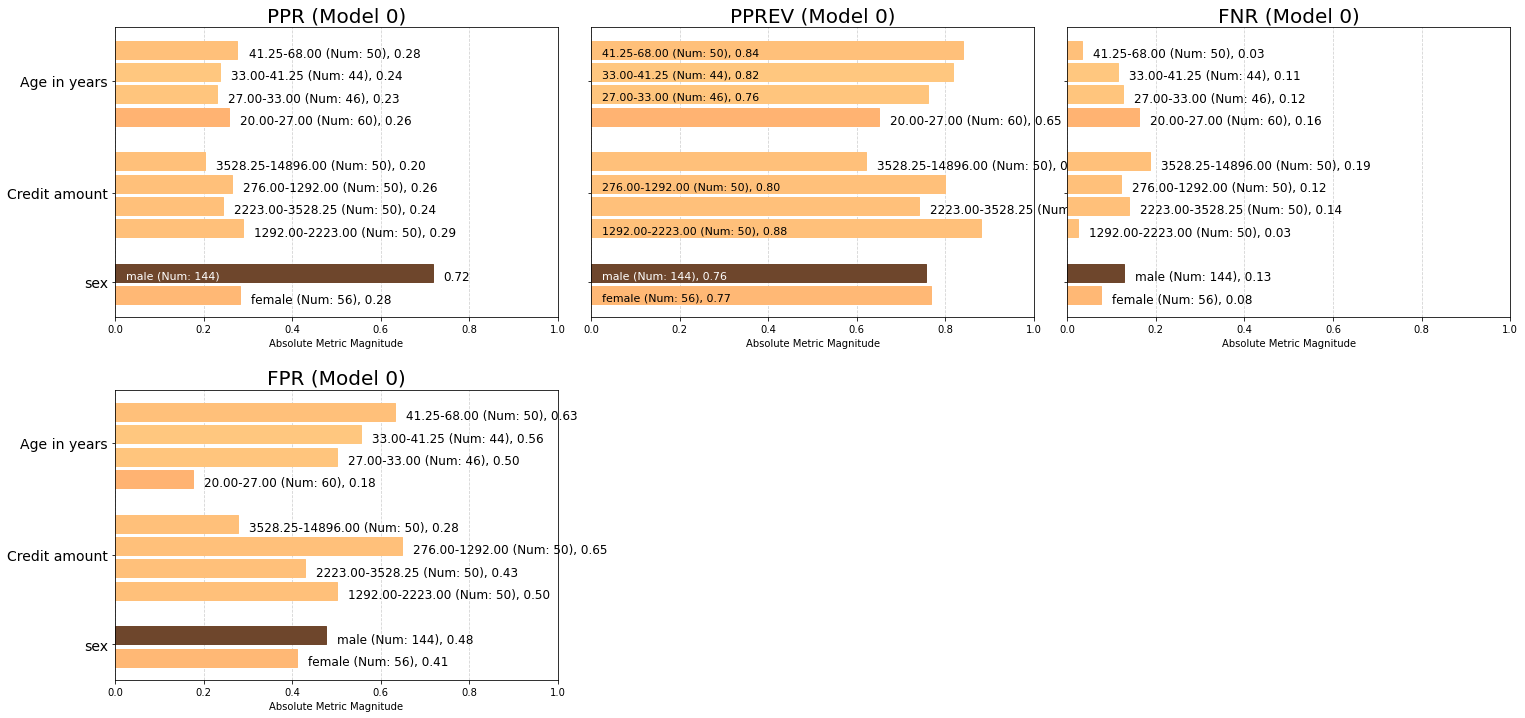

<Figure size 432x288 with 0 Axes>

In [35]:
from aequitas.plotting import Plot
    
plt.figure(figsize = (25, 15))
aqp = Plot()



#fpr_plot = aqp.plot_group_metric(xtab, 'fpr')
fpr_plot = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'])

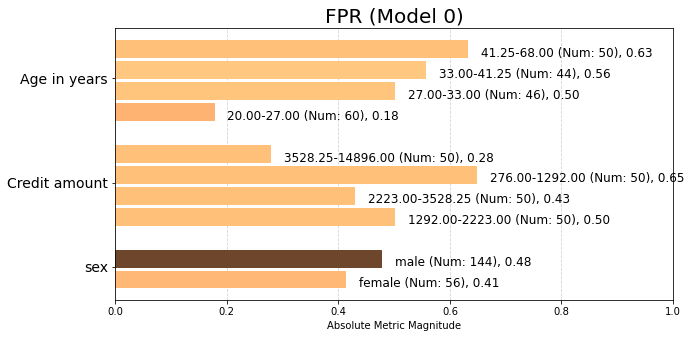

In [21]:
from aequitas.plotting import Plot

aqp = Plot()
fpr_plot = aqp.plot_group_metric(xtab, 'fpr', min_group_size=0.05)

In [22]:
df

,sex,Credit amount,Age in years,score,label_value
521,female,2223.00-3528.25,20.00-27.00,1.0,0
737,male,3528.25-14896.00,33.00-41.25,0.0,1
740,male,2223.00-3528.25,27.00-33.00,0.0,1
660,male,1292.00-2223.00,20.00-27.00,1.0,1
411,male,3528.25-14896.00,33.00-41.25,1.0,1
...,...,...,...,...,...
408,male,2223.00-3528.25,20.00-27.00,1.0,1
332,female,3528.25-14896.00,20.00-27.00,0.0,0
208,male,3528.25-14896.00,20.00-27.00,0.0,1
613,female,3528.25-14896.00,20.00-27.00,1.0,1


In [26]:
from aequitas.bias import Bias

group_dict = {'Age in years':'20.00-27.00', 
            'Credit amount':'2223.00-3528.25',
            'sex' : 'female'
            }
#group_dict = {'Job':'unskilled - resident', 
#            'Personal status and sex':'female:divorced/separated/married',
#            'Housing' : 'rent'
#            }

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
                    original_df=df, 
                    ref_groups_dict=group_dict, 
                    alpha=0.05, 
                    check_significance=False)

get_disparity_predefined_group()


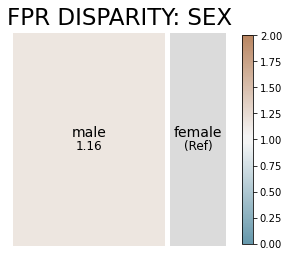

In [27]:
#attrib = 'Personal status and sex'
attrib = 'sex'

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name=attrib)

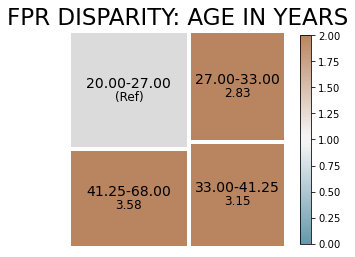

In [29]:
attrib = 'Age in years'

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name=attrib)

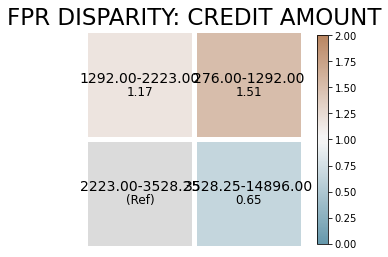

In [31]:
attrib = 'Credit amount'

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name=attrib)

In [32]:
from aequitas.fairness import Fairness
    
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

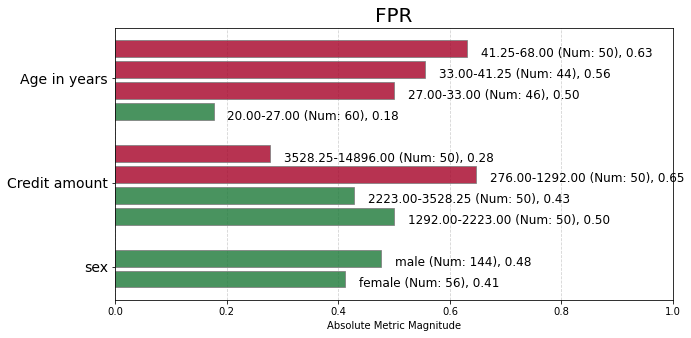

In [33]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True, min_group_size=0.05)